In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

### Convert the dataset to TFRecords

In [2]:
from datasets import convert_insulators
convert_insulators.run('/workspace/JiaXuejian')

Dataset files already exist. Exiting without re-creating them.


### Download the Inception V1 checkpoint

In [3]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.



### Apply Pre-trained Inception V1 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


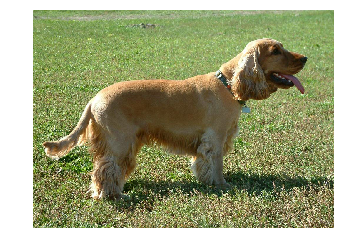

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [4]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [5]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [6]:
# Note that this may take several minutes.

import os

from datasets import insulators
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size

insulators_data_dir = '/workspace/JiaXuejian'

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned1/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = insulators.get_split('train', insulators_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1000)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:global step 82: loss = 0.6835 (2.190 sec/step)
INFO:tensorflow:global step 83: loss = 0.6978 (1.611 sec/step)
INFO:tensorflow:global step 84: loss = 0.5607 (2.306 sec/step)
INFO:tensorflow:global step 85: loss = 0.5906 (1.658 sec/step)
INFO:tensorflow:global step 86: loss = 0.5745 (1.654 sec/step)
INFO:tensorflow:global step 87: loss = 0.7204 (1.803 sec/step)
INFO:tensorflow:global step 88: loss = 0.6022 (2.024 sec/step)
INFO:tensorflow:global step 89: loss = 0.6282 (1.985 sec/step)
INFO:tensorflow:global step 90: loss = 0.5569 (2.015 sec/step)
INFO:tensorflow:global step 91: loss = 0.5540 (1.763 sec/step)
INFO:tensorflow:global step 92: loss = 0.6130 (1.713 sec/step)
INFO:tensorflow:global step 93: loss = 1.1404 (1.879 sec/step)
INFO:tensorflow:global step 94: loss = 0.5746 (2.117 sec/step)
INFO:tensorflow:global step 95: loss = 0.5851 (2.209 sec/step)
INFO:tensorflow:global step 96: loss = 0.5802 (1.676 sec/step)
INFO:tensorflow:global step 97: loss = 0.5236 (1.478 se

INFO:tensorflow:global step 211: loss = 0.6837 (1.272 sec/step)
INFO:tensorflow:global step 212: loss = 0.6585 (1.133 sec/step)
INFO:tensorflow:global step 213: loss = 0.6838 (1.042 sec/step)
INFO:tensorflow:global step 214: loss = 0.7713 (1.308 sec/step)
INFO:tensorflow:global step 215: loss = 0.6834 (1.899 sec/step)
INFO:tensorflow:global step 216: loss = 0.5352 (1.354 sec/step)
INFO:tensorflow:global step 217: loss = 0.6188 (1.258 sec/step)
INFO:tensorflow:global step 218: loss = 0.8342 (1.396 sec/step)
INFO:tensorflow:global step 219: loss = 0.4663 (1.553 sec/step)
INFO:tensorflow:global step 220: loss = 0.4578 (1.559 sec/step)
INFO:tensorflow:global step 221: loss = 0.5273 (1.235 sec/step)
INFO:tensorflow:global step 222: loss = 0.4964 (1.279 sec/step)
INFO:tensorflow:global step 223: loss = 0.4721 (1.478 sec/step)
INFO:tensorflow:global step 224: loss = 0.6984 (2.160 sec/step)
INFO:tensorflow:global step 225: loss = 0.4805 (1.573 sec/step)
INFO:tensorflow:global step 226: loss = 

INFO:tensorflow:global step 340: loss = 0.4615 (1.529 sec/step)
INFO:tensorflow:global step 341: loss = 0.4318 (1.524 sec/step)
INFO:tensorflow:global step 342: loss = 0.3623 (1.105 sec/step)
INFO:tensorflow:global step 343: loss = 0.4985 (0.986 sec/step)
INFO:tensorflow:global step 344: loss = 0.3461 (1.394 sec/step)
INFO:tensorflow:global step 345: loss = 0.4807 (1.146 sec/step)
INFO:tensorflow:global step 346: loss = 0.3593 (1.205 sec/step)
INFO:tensorflow:global step 347: loss = 0.3463 (1.461 sec/step)
INFO:tensorflow:global step 348: loss = 0.4606 (0.925 sec/step)
INFO:tensorflow:global step 349: loss = 0.5958 (1.210 sec/step)
INFO:tensorflow:global step 350: loss = 0.3536 (1.676 sec/step)
INFO:tensorflow:global step 351: loss = 0.3653 (1.360 sec/step)
INFO:tensorflow:global step 352: loss = 0.3894 (1.240 sec/step)
INFO:tensorflow:global step 353: loss = 0.4191 (1.241 sec/step)
INFO:tensorflow:global step 354: loss = 0.4480 (1.406 sec/step)
INFO:tensorflow:global step 355: loss = 

INFO:tensorflow:global step 466: loss = 0.2965 (1.651 sec/step)
INFO:tensorflow:global step 467: loss = 0.2888 (1.828 sec/step)
INFO:tensorflow:global step 468: loss = 0.3187 (1.502 sec/step)
INFO:tensorflow:global step 469: loss = 0.2882 (1.776 sec/step)
INFO:tensorflow:global step 470: loss = 0.2855 (1.842 sec/step)
INFO:tensorflow:global step 471: loss = 0.3733 (1.531 sec/step)
INFO:tensorflow:global step 472: loss = 0.3981 (1.588 sec/step)
INFO:tensorflow:global step 473: loss = 0.3791 (1.533 sec/step)
INFO:tensorflow:global step 474: loss = 0.2803 (1.134 sec/step)
INFO:tensorflow:global step 475: loss = 0.2847 (1.546 sec/step)
INFO:tensorflow:global step 476: loss = 0.2756 (1.782 sec/step)
INFO:tensorflow:global step 477: loss = 0.2782 (1.641 sec/step)
INFO:tensorflow:global step 478: loss = 0.2761 (1.334 sec/step)
INFO:tensorflow:global step 479: loss = 0.3066 (1.824 sec/step)
INFO:tensorflow:global step 480: loss = 0.2875 (1.596 sec/step)
INFO:tensorflow:global step 481: loss = 

INFO:tensorflow:global step 595: loss = 0.3721 (1.930 sec/step)
INFO:tensorflow:global step 596: loss = 0.3948 (1.851 sec/step)
INFO:tensorflow:global step 597: loss = 0.3643 (1.431 sec/step)
INFO:tensorflow:global step 598: loss = 0.3261 (2.027 sec/step)
INFO:tensorflow:global step 599: loss = 0.3340 (1.821 sec/step)
INFO:tensorflow:global step 600: loss = 0.3929 (1.008 sec/step)
INFO:tensorflow:global step 601: loss = 0.3271 (1.938 sec/step)
INFO:tensorflow:global step 602: loss = 0.3092 (1.589 sec/step)
INFO:tensorflow:global step 603: loss = 0.4438 (1.887 sec/step)
INFO:tensorflow:global step 604: loss = 0.4035 (1.802 sec/step)
INFO:tensorflow:global step 605: loss = 0.2956 (1.762 sec/step)
INFO:tensorflow:global step 606: loss = 0.6905 (1.387 sec/step)
INFO:tensorflow:global step 607: loss = 0.2914 (1.359 sec/step)
INFO:tensorflow:global step 608: loss = 0.4522 (1.748 sec/step)
INFO:tensorflow:global step 609: loss = 0.3137 (1.454 sec/step)
INFO:tensorflow:global step 610: loss = 

INFO:tensorflow:global step 724: loss = 0.2827 (1.491 sec/step)
INFO:tensorflow:global step 725: loss = 0.2321 (1.805 sec/step)
INFO:tensorflow:global step 726: loss = 0.2348 (1.279 sec/step)
INFO:tensorflow:global step 727: loss = 0.2691 (1.494 sec/step)
INFO:tensorflow:global step 728: loss = 0.2986 (1.726 sec/step)
INFO:tensorflow:global step 729: loss = 0.2427 (1.560 sec/step)
INFO:tensorflow:global step 730: loss = 0.2454 (1.364 sec/step)
INFO:tensorflow:global step 731: loss = 0.2211 (1.508 sec/step)
INFO:tensorflow:global step 732: loss = 0.2684 (1.502 sec/step)
INFO:tensorflow:global step 733: loss = 0.2450 (1.672 sec/step)
INFO:tensorflow:global step 734: loss = 0.2807 (1.821 sec/step)
INFO:tensorflow:global step 735: loss = 0.2682 (1.589 sec/step)
INFO:tensorflow:global step 736: loss = 0.2220 (1.283 sec/step)
INFO:tensorflow:global step 737: loss = 0.2167 (1.838 sec/step)
INFO:tensorflow:global step 738: loss = 0.2409 (1.511 sec/step)
INFO:tensorflow:global step 739: loss = 

INFO:tensorflow:global step 850: loss = 0.2415 (1.487 sec/step)
INFO:tensorflow:global step 851: loss = 0.2113 (1.516 sec/step)
INFO:tensorflow:global step 852: loss = 0.1947 (1.735 sec/step)
INFO:tensorflow:global step 853: loss = 0.1928 (1.802 sec/step)
INFO:tensorflow:global step 854: loss = 0.1977 (1.500 sec/step)
INFO:tensorflow:global step 855: loss = 0.1925 (1.724 sec/step)
INFO:tensorflow:global step 856: loss = 0.1941 (1.430 sec/step)
INFO:tensorflow:global step 857: loss = 0.1905 (1.789 sec/step)
INFO:tensorflow:global step 858: loss = 0.1932 (1.618 sec/step)
INFO:tensorflow:global step 859: loss = 0.1896 (1.487 sec/step)
INFO:tensorflow:global step 860: loss = 0.1883 (1.435 sec/step)
INFO:tensorflow:global step 861: loss = 0.3715 (1.621 sec/step)
INFO:tensorflow:global step 862: loss = 0.2605 (1.608 sec/step)
INFO:tensorflow:global step 863: loss = 0.1894 (2.070 sec/step)
INFO:tensorflow:global step 864: loss = 0.3260 (1.110 sec/step)
INFO:tensorflow:global step 865: loss = 

INFO:tensorflow:global step 979: loss = 0.6684 (1.303 sec/step)
INFO:tensorflow:global step 980: loss = 0.8449 (1.798 sec/step)
INFO:tensorflow:global step 981: loss = 0.8614 (1.428 sec/step)
INFO:tensorflow:global step 982: loss = 0.8228 (1.438 sec/step)
INFO:tensorflow:global step 983: loss = 0.6653 (1.499 sec/step)
INFO:tensorflow:global step 984: loss = 1.4234 (1.427 sec/step)
INFO:tensorflow:global step 985: loss = 1.0136 (1.365 sec/step)
INFO:tensorflow:global step 986: loss = 1.0786 (1.393 sec/step)
INFO:tensorflow:global step 987: loss = 1.0757 (1.428 sec/step)
INFO:tensorflow:global step 988: loss = 0.8939 (1.260 sec/step)
INFO:tensorflow:global step 989: loss = 0.7399 (1.594 sec/step)
INFO:tensorflow:global step 990: loss = 1.6239 (1.463 sec/step)
INFO:tensorflow:global step 991: loss = 0.8619 (1.737 sec/step)
INFO:tensorflow:global step 992: loss = 0.7693 (1.672 sec/step)
INFO:tensorflow:global step 993: loss = 2.8291 (1.242 sec/step)
INFO:tensorflow:global step 994: loss = 

### Apply fine tuned model to some images.

Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned1/model.ckpt-1000


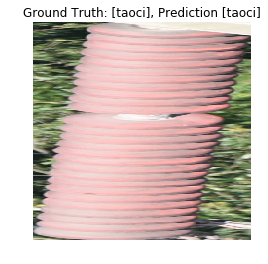

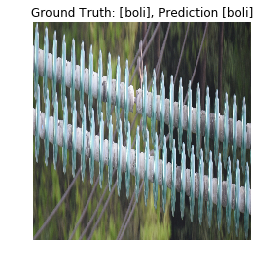

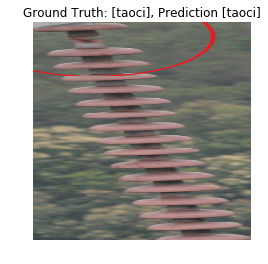

In [7]:
import numpy as np
import tensorflow as tf
from datasets import insulators
from nets import inception

from tensorflow.contrib import slim

insulators_data_dir = '/workspace/JiaXuejian'
image_size = inception.inception_v1.default_image_size
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = insulators.get_split('train', insulators_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()